<a href="https://colab.research.google.com/github/tanuja1708/EEG-emotions/blob/main/seed_7_(HAN%2C_BI_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Attention, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
import pickle

In [3]:
df = pd.read_csv('/content/de_lds_with_labels(310 seed7).csv')

# Features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=7)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape: (samples, 62 timesteps, 5 features)
X_reshaped = X_scaled.reshape(-1, 62, 5)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)


In [4]:
def build_han_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    attention = Attention()([x, x])  # Self-attention
    x = Concatenate()([x, attention])
    x = Bidirectional(LSTM(32))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [5]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

model = build_han_model((62, 5), 7)
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)


Epoch 1/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - accuracy: 0.2469 - loss: 1.8662 - val_accuracy: 0.4467 - val_loss: 1.4304
Epoch 2/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.4994 - loss: 1.3049 - val_accuracy: 0.7411 - val_loss: 0.6972
Epoch 3/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7341 - loss: 0.7350 - val_accuracy: 0.9147 - val_loss: 0.2812
Epoch 4/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.8467 - loss: 0.4332 - val_accuracy: 0.9324 - val_loss: 0.2036
Epoch 5/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9002 - loss: 0.2889 - val_accuracy: 0.9692 - val_loss: 0.1070
Epoch 6/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9245 - loss: 0.2198 - val_accuracy: 0.9842 - val_loss: 0.0505
Epoch 7/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9404 - loss: 0.1745 - val_accuracy: 0.9952 - val_loss: 0.0175
Epoch 8/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9550 -

In [6]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9990 - loss: 0.0038
Test Accuracy: 99.85%


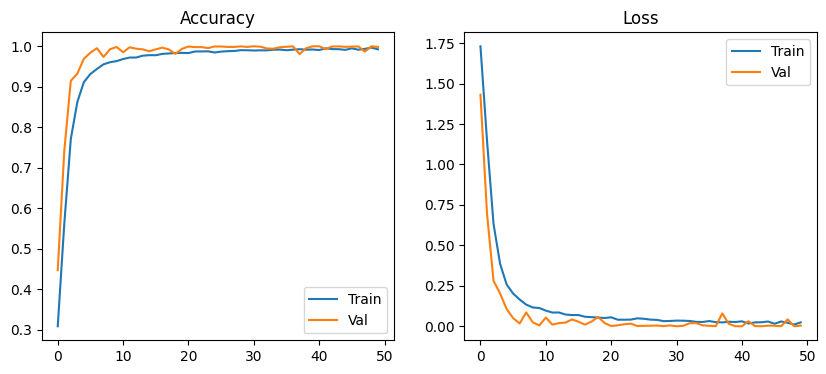

In [7]:
# Accuracy/loss plots
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()


436/436 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Classification Report:
               precision    recall  f1-score   support

       Anger       1.00      1.00      1.00      2235
     Disgust       1.00      0.99      1.00      1856
        Fear       1.00      1.00      1.00      2264
       Happy       1.00      1.00      1.00      1604
     Neutral       1.00      1.00      1.00      1322
         Sad       1.00      1.00      1.00      2438
    Surprise       1.00      1.00      1.00      2230

    accuracy                           1.00     13949
   macro avg       1.00      1.00      1.00     13949
weighted avg       1.00      1.00      1.00     13949



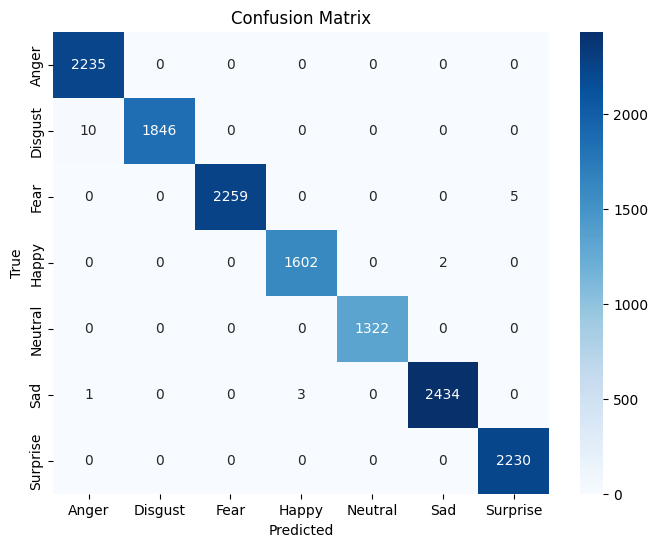

In [8]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [9]:
model.save("eeg_emotion_han_model.h5")
with open('eeg_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('eeg_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Model and preprocessors saved.")

Model and preprocessors saved.


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 62, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 62, 128)   │     35,840 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 62, 128)   │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 62, 256)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     73,984 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │        455 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 343,831 (1.31 MB)

 Trainable params: 114,567 (447.53 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 229,136 (895.07 KB)